# Model Comparisson

In [83]:
from pathlib import Path

import mlflow
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt

In [84]:
DATA_PATH = Path("../../data/processed")


## First: Start the MLFlow-Server for logging the experiments

Run the following command: 

Powershell:

mlflow server ` 
    --backend-store-uri sqlite:///mlflow.db ` 
    --default-artifact-root ./mlartifacts/  


Bash / Git Bash / WSL / Linux / macOS
mlflow server \
  --backend-store-uri sqlite:///mlflow.db \
  --default-artifact-root ./mlartifacts


In [12]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

## Load the best models (LSTM, Bayesian LSTM, Propeht) and Perfomance Metrics

In [ ]:
performance_df = pd.DataFrame(columns=["Model", "RSME_Overall", "MAE_Overall", "RSME_h1", "RSME_h4", "RSME_h12", "RSME_h24", "RSME_h48", "RSME_h96"])

In [14]:
LSTM_RUN_ID = "9de69e1bb0844ca29f3267bca6f7674e"
BAYESIAN_LSTM_RUN_ID = "2ccd3a12be4d4ec484be5af5fc8ab4e3"
PROPHET_RUN_ID = "73f7dd056c9c4b38907b476f7bf47615"

In [ ]:
mlflow.set_experiment("load_forecasting_bayesian_lstm")

ranked_checkpoints = mlflow.search_logged_models(
    filter_string=f"source_run_id='{BAYESIAN_LSTM_RUN_ID}'",
    order_by=[{"field_name": "metrics.val_nll", "ascending": True}],
    output_format="list",
)

best_checkpoint = ranked_checkpoints[0]

baysian_lstm = mlflow.pytorch.load_model(best_checkpoint.model_uri) # pyright: ignore

run = mlflow.get_run(run_id=BAYESIAN_LSTM_RUN_ID)
metrics = run.data.metrics

rmse = run.data.metrics["test_rmse_unscaled"]
rmse_h1 = run.data.metrics["rmse_h1"]
rmse_h4 = run.data.metrics["rmse_h4"]
rmse_h12 = run.data.metrics["rmse_h12"]
rmse_h24 = run.data.metrics["rmse_h24"]
rmse_h48 = run.data.metrics["rmse_h48"]
rmse_h96 = run.data.metrics["rmse_h96"]
mae = run.data.metrics["test_mae_unscaled"]

performance_df.loc[len(performance_df)] = ["bayesian_lstm", rmse, mae, rmse_h1, rmse_h4, rmse_h12, rmse_h24, rmse_h48, rmse_h96]

In [ ]:
mlflow.set_experiment("load_forecasting_vanilla_lstm")

ranked_checkpoints = mlflow.search_logged_models(
    filter_string=f"source_run_id='{LSTM_RUN_ID}'",
    order_by=[{"field_name": "metrics.val_mse", "ascending": True}],
    output_format="list",
)

best_checkpoint = ranked_checkpoints[0]

lstm = mlflow.pytorch.load_model(best_checkpoint.model_uri) # pyright: ignore

run = mlflow.get_run(run_id=LSTM_RUN_ID)
metrics = run.data.metrics

rmse = run.data.metrics["test_rmse_unscaled"]
rmse_h1 = run.data.metrics["rmse_h1"]
rmse_h4 = run.data.metrics["rmse_h4"]
rmse_h12 = run.data.metrics["rmse_h12"]
rmse_h24 = run.data.metrics["rmse_h24"]
rmse_h48 = run.data.metrics["rmse_h48"]
rmse_h96 = run.data.metrics["rmse_h96"]
mae = run.data.metrics["test_mae_unscaled"]

performance_df.loc[len(performance_df)] = ["lstm", rmse, mae, rmse_h1, rmse_h4, rmse_h12, rmse_h24, rmse_h48, rmse_h96]


In [ ]:
mlflow.set_experiment("load_forecasting_prophet")

ranked_checkpoints = mlflow.search_logged_models(
    filter_string=f"source_run_id='{PROPHET_RUN_ID}'",
    order_by=[{"field_name": "metrics.val_mse", "ascending": True}],
    output_format="list",
)

best_checkpoint = ranked_checkpoints[0]

prophet_model = mlflow.prophet.load_model(best_checkpoint.model_uri) # pyright: ignore

mlflow.get_run(run_id=PROPHET_RUN_ID)

run = mlflow.get_run(run_id=PROPHET_RUN_ID)
metrics = run.data.metrics

rmse = run.data.metrics["rmse"]
rmse_h1 = run.data.metrics["rmse_h1"]
rmse_h4 = run.data.metrics["rmse_h4"]
rmse_h12 = run.data.metrics["rmse_h12"]
rmse_h24 = run.data.metrics["rmse_h24"]
rmse_h48 = run.data.metrics["rmse_h48"]
rmse_h96 = run.data.metrics["rmse_h96"]
mae = run.data.metrics["mae"]

performance_df.loc[len(performance_df)] = ["prophet", rmse, mae, rmse_h1, rmse_h4, rmse_h12, rmse_h24, rmse_h48, rmse_h96]


## Comparisson Plots

### RSME, MAE and Horizon-Error-Profile

In [43]:
overall_df = performance_df[["Model", "RSME_Overall", "MAE_Overall"]]

overall_long = overall_df.melt(
    id_vars="Model",
    var_name="Metric",
    value_name="Error"
)

Text(0.5, 1.0, 'Overall Forecasting Performance')

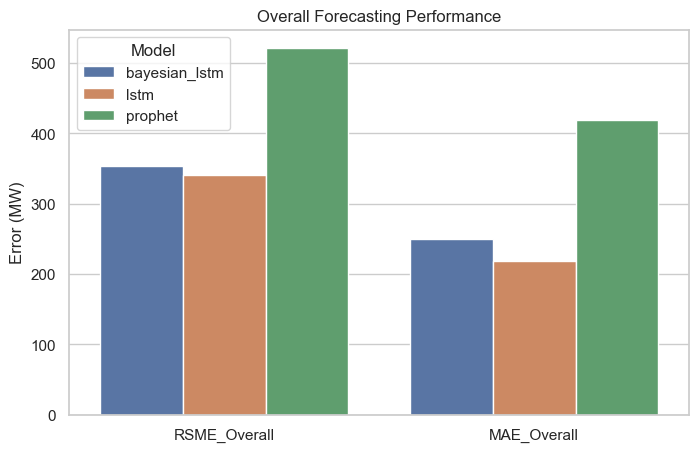

In [64]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(
    data=overall_long,
    x="Metric",
    y="Error",
    hue="Model",
    errorbar=None,
    ax=ax
)

ax.set_ylabel("Error (MW)")
ax.set_xlabel("")
ax.set_title("Overall Forecasting Performance")


In [46]:
horizon_cols = ["RSME_h1", "RSME_h4", "RSME_h12", "RSME_h24", "RSME_h48", "RSME_h96"]

horizon_df = performance_df[["Model"] + horizon_cols]

horizon_long = horizon_df.melt(
    id_vars="Model",
    var_name="Horizon",
    value_name="RMSE"
)

horizon_long["Horizon"] = (
    horizon_long["Horizon"]
    .str.replace("RSME_h", "")
    .astype(int)
)

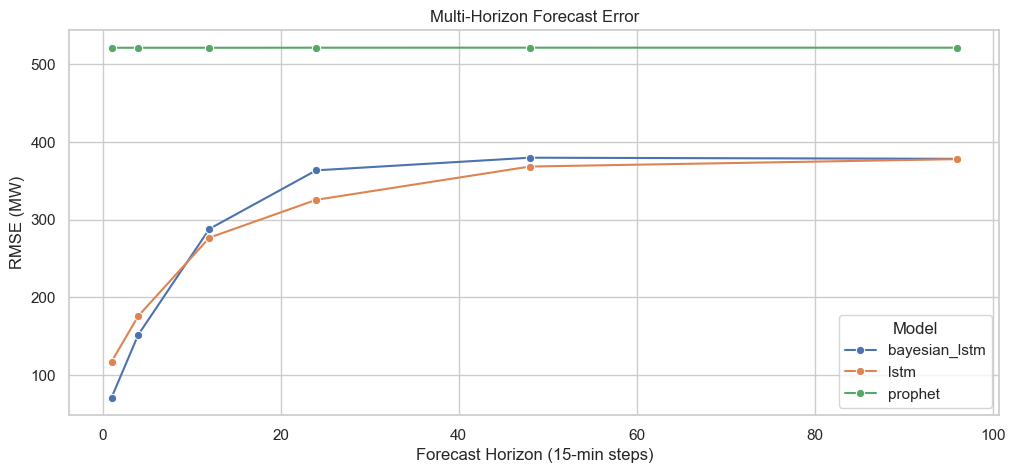

In [65]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(
    data=horizon_long,
    x="Horizon",
    y="RMSE",
    hue="Model",
    marker="o",
    ax=ax
)

ax.set_xlabel("Forecast Horizon (15-min steps)")
ax.set_ylabel("RMSE (MW)")
ax.set_title("Multi-Horizon Forecast Error")

ax.legend(title="Model")

## Sample predictions

In [87]:
raw_data = pd.read_parquet(DATA_PATH /  "data_combined.parquet")

raw_data

,actual_load_mw,t2m_future,ssrd_future,tp_future,wind_speed_future,is_weekday,is_holiday
period,,,,,,,
2018-10-01 00:00:00+00:00,5256.0,277.421722,0.0,0.000000e+00,1.758537,True,0
2018-10-01 00:15:00+00:00,5204.0,277.421722,0.0,0.000000e+00,1.758537,True,0
2018-10-01 00:30:00+00:00,5178.0,277.421722,0.0,0.000000e+00,1.758537,True,0
2018-10-01 00:45:00+00:00,5151.0,277.421722,0.0,0.000000e+00,1.758537,True,0
2018-10-01 01:00:00+00:00,5187.0,277.252350,0.0,6.201566e-08,1.709355,True,0
...,...,...,...,...,...,...,...
2025-10-08 23:00:00+00:00,5667.0,281.028931,0.0,8.888660e-09,1.151026,True,0
2025-10-08 23:15:00+00:00,5618.0,281.028931,0.0,8.888660e-09,1.151026,True,0
2025-10-08 23:30:00+00:00,5534.0,281.028931,0.0,8.888660e-09,1.151026,True,0


In [99]:
normal_winter_week = raw_data.loc["2024-11-04 00:00:00+00:00" : "2024-11-10 23:59:59+00:00"]
normal_summer_week = raw_data.loc["2024-06-17 00:00:00+00:00" : "2024-06-17 23:59:59+00:00"]
winter_holiday_period = raw_data.loc["2023-12-01 00:00:00+00:00" : "2024-02-01 23:59:59+00:00"]

In [ ]:
def preprocess_to_prophet_df(df, target, ):
    prophet_df = df.rename(columns={target: "y"})
    prophet_df["ds"] = prophet_df.index
    prophet_df["ds"]=prophet_df["ds"].dt.tz_convert(None)
    return prophet_df

def preprocess_to_lstm_input(df):
    pass

In [111]:
# Load the test data Normal Weekday, Holiday, Weekend
# Plot the predictions against the actual values 

# Data for a normal week: 2024: 04.11 - 10.11
# Data for a normal week in summer: 2024: 170.06 - 23.06
# Holiday: 01.12.2023-31.01.2024

y_hat_prophet = prophet_model.predict(preprocess_to_prophet_df(winter_holiday_period, target="actual_load_mw"))["yhat"].values

# Get the predictions for each model